# Visual analysis of findings till now.

### Initialization

Loading the data file and writing some important functions to be used later on.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
import scipy 
csv = '/home/shikha/github/COVID-19/notebooks/unnormalized.csv'
df = pd.read_csv(csv)
df.drop(columns=['Unnamed: 0'],inplace=True)
df

/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


,Sample No.,Patient ID,Study ID,Age,Gender,BMI,Symptoms Presented,Symptoms Present?,Fever,Cough,...,ERYTHROCYTE SEDIMENTATION RATE,PRO-CALCITONIN,D-DIMER,IL-6,SERUM FERRITIN,ECG,CXR,CORADS SCORE ON HRCT,PATIENT CATEGORY,PLASMA THERAPY
0,1013,IGIB1040201013,IGIB1040201013-1,53,1,22.5,"fever, cough,breathlessness",1,1,1,...,8.0,NaN,98,NaN,NaN,sinus rhythm,normal,4,5a,No
1,1014,IGIB1040201014,IGIB1040201014-1,26,0,25.7,asymptomatic,0,0,0,...,NaN,NaN,0.2,NaN,NaN,sinus rhythm,normal,0,5b,No
2,1015,IGIB1040201015,IGIB1040201015-1,28,1,22.2,asymptomatic,0,0,0,...,4.0,0.20,0.35,NaN,NaN,sinus rhythm,normal,0,5b,No
3,1016,IGIB1040201016,IGIB1040201016-1,73,1,21.5,"fever, cough,breathlessness",1,1,1,...,NaN,NaN,NaN,63.31,NaN,sinus rhythm,normal,5,4,No
4,1060,IGIB1040201060,IGIB1040201060-1,49,1,27.4,"fever,cough",1,1,1,...,8.0,NaN,350.55,4.33,NaN,sinus rhythm,normal,5,4,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,950,IGIB104020950,IGIB104020950-1,53,1,27.2,"fever, cough,breathlessness",1,1,1,...,14.0,NaN,410,NaN,NaN,sinus rhythm,normal,5,4,No
171,965,IGIB104020965,IGIB104020965-1,33,1,26.0,"fever, cough,breathlessness",1,1,1,...,6.0,NaN,1120,37.90,NaN,sinus tachycardia,normal,5,4,No
172,9667,IGIB1040209667,IGIB1040209667-1,70,1,21.4,"fever, breathlessness",1,1,0,...,8.0,0.54,1078,735.60,NaN,sinus rhythm,normal,5,4,No
173,9759,IGIB1040209759,IGIB1040209759-1,65,0,22.4,breathlessness and cough,1,0,1,...,6.0,NaN,1224,NaN,NaN,sinus rhythm,normal,6,4,No


In [2]:
def plot_count(new_column_name,old_column,groups,group_names):
    df[new_column_name] = pd.cut(df[old_column], groups, labels=group_names, include_lowest=True )
    return df
    
def contingency(data,column):
    grouped = data.groupby([column,'Result'],as_index=False).size()
    grouped_pivot = grouped.pivot(index=column,columns='Result')
    return grouped_pivot  

Note: Outcome is our result variable. An outcome of '0' indictaes that the patient survived, '1' indicates death.

We observed that outcome is heavily correlated to ventilatory support required. We replaced the null values of Outcome as 0 if no ventilatory support was needed, and 1 if ventilatory support severity is 1 (Non-invasive ventilation) or 2 (Intubation).



## Analysis

### Age

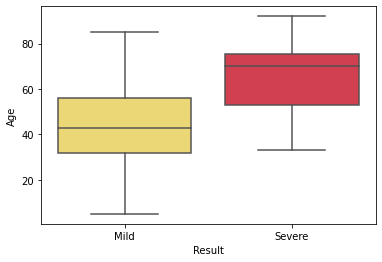

In [3]:
df['Result'] = df.Outcome.replace({1: "Severe", 0:"Mild"})
ax = sns.boxplot(x="Result", y="Age", data=df,palette={"Severe": "#e8283e", "Mild": "#ffe461"})

From the box plot, we can see that fatal outcome is more prominent in people aged over 60.

size       
Result    Mild Severe
AgeGroups            
Below60    122      8
Above60     29     16

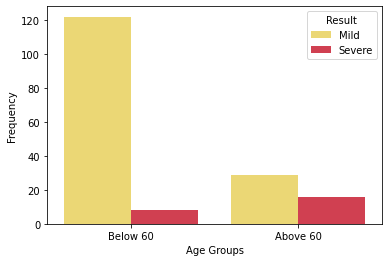

In [4]:
age_groups = [0,59,100]
group_names = ['Below60','Above60']
df = plot_count('AgeGroups','Age',age_groups,group_names)
age = df[['AgeGroups','Result']]
c_age = contingency(age,'AgeGroups')

# Multi-bar Plot
cp = sns.countplot(x="AgeGroups", hue="Result", data=df, 
                   palette={"Severe": "#e8283e", "Mild": "#ffe461"})
cp.set_xticklabels(["Below 60", "Above 60"])
cp.set_xlabel("Age Groups")
cp.set_ylabel("Frequency")
c_age

In [5]:
c = pd.crosstab(df.AgeGroups, df.Result)
c = c.apply(lambda x: x/x.sum(), axis=1)
c  

Result,Mild,Severe
AgeGroups,,
Below60,0.938462,0.061538
Above60,0.644444,0.355556


In [6]:
c["odds"] = c.loc[:, 'Severe'] / c.loc[:, 'Mild']
c

Result,Mild,Severe,odds
AgeGroups,,,
Below60,0.938462,0.061538,0.065574
Above60,0.644444,0.355556,0.551724


The ‘odds’ show that the probability of a person aged below 60 having fatal outcome is substantially lower than a person aged above 60(6% vs 55%) that reflects very well in the odds. Odds ratios are common to use while working with two population groups.

In [7]:
c.odds.Above60 / c.odds.Below60

8.413793103448276

The ratio comes out to be 8.4 which indicates a person above 60 has a 8 times greater chance of having a fatal outcome. (8x as likely)

## Gender

size       
Result Mild Severe
Sex               
Female   62      6
Male     89     18

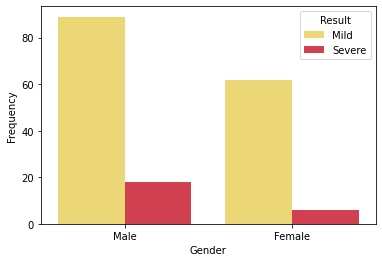

In [8]:
df["Sex"] = df.Gender.replace({1: "Male", 0:"Female"})
df_gender = df[['Sex','Result']]
c_gender = contingency(df_gender,'Sex')
cp = sns.countplot(x="Sex", hue="Result", data=df, 
                   palette={"Severe": "#e8283e", "Mild": "#ffe461"})
cp.set_xlabel("Gender")
cp.set_ylabel("Frequency")
c_gender

In [9]:
c = pd.crosstab(df.Sex, df.Result)
c = c.apply(lambda x: x/x.sum(), axis=1)
c  

Result,Mild,Severe
Sex,,
Female,0.911765,0.088235
Male,0.831776,0.168224


In [10]:
c["odds"] = c.loc[:, 'Severe'] / c.loc[:, 'Mild']
c

Result,Mild,Severe,odds
Sex,,,
Female,0.911765,0.088235,0.096774
Male,0.831776,0.168224,0.202247


The ‘odds’ show that the probability of a female having fatal outcome is substantially lower than a male(9% vs 20%) that reflects very well in the odds. Odds ratios are common to use while working with two population groups.

In [11]:
c.odds.Male / c.odds.Female

2.089887640449438

The ratio comes out to be 2.08 which indicates a man has a 2.08 times greater chance of having a fatal outcome. (twice as likely)

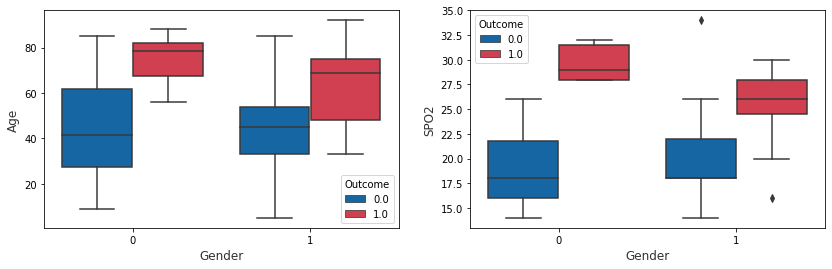

In [12]:
# Visualizing 3-D mix data using box plots
# leveraging the concepts of hue and axes for > 1 categorical dimensions
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.boxplot(x="Gender", y="Age", hue="Outcome",
               data=df, palette={1: "#e8283e", 0: "#0069bb"}, ax=ax1)
ax1.set_xlabel("Gender",size = 12,alpha=0.8)
ax1.set_ylabel("Age",size = 12,alpha=0.8)


sns.boxplot(x="Gender", y="Respiratory rate(breaths per minute)", hue="Outcome",
               data=df, palette={1: "#e8283e", 0: "#0069bb"}, ax=ax2)
ax2.set_xlabel("Gender",size = 12,alpha=0.8)
ax2.set_ylabel("SPO2",size = 12,alpha=0.8)
l = plt.legend(loc='best', title='Outcome')

In [13]:
age_gender = df[['AgeGroups','Gender','Outcome']]
basics = age_gender.groupby(['AgeGroups','Gender'],as_index=False).mean()
basics_pivot = basics.pivot(index='Gender',columns='AgeGroups')
basics_pivot

Outcome          
AgeGroups   Below60   Above60
Gender                       
0          0.021739  0.227273
1          0.083333  0.478261

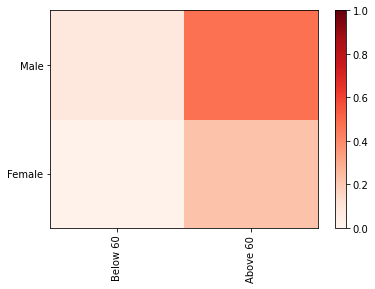

In [14]:
%matplotlib inline
plt.figure
fig, ax = plt.subplots()
im = ax.pcolor(basics_pivot, cmap='Reds',vmin = 0, vmax=1)

#label names
row_labels = ['Below 60','Above 60']
col_labels = ['Female','Male']

#move ticks and labels to the center
ax.set_xticks(np.arange(basics_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(basics_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.savefig('agegender.png')
plt.show()

From the analysis above, we can see clearly that covid-affected males above the age of 60 are at the highest risk of mortality from the disease.

## Respiratory Rate
(breaths per minute)

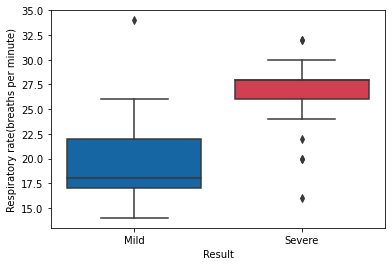

In [15]:
ax = sns.boxplot(x="Result", y="Respiratory rate(breaths per minute)", data=df,palette={"Severe": "#e8283e", "Mild": "#0069bb"})

Respiratory breath can be used as a distinguishing factor. People with a higher rate than 25 were more likely to have a fatal outcome

### Vital Signs

Text(0.5, 0, 'Respiratory Rate')

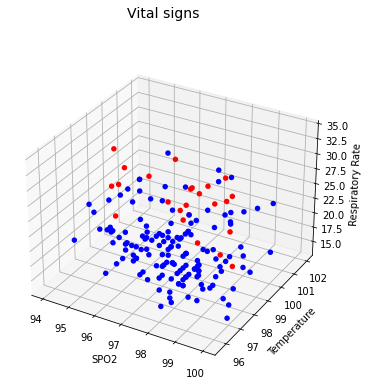

In [16]:
# Visualizing 4-D mix data using scatter plots
# leveraging the concepts of hue and depth
fig = plt.figure(figsize=(8, 6))
t = fig.suptitle('Vital signs', fontsize=14)
ax = fig.add_subplot(111, projection='3d')

xs = list(df['SPO2'])
ys = list(df['Temp'])
zs = list(df['Respiratory rate(breaths per minute)'])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]
colors = ['red' if ot == 1 else 'blue' for ot in list(df['Outcome'])]

for data, color in zip(data_points, colors):
    x, y, z = data
    ax.scatter(x, y, z, alpha=1, c=color, edgecolors='none', s=30)

ax.set_xlabel('SPO2')
ax.set_ylabel('Temperature')
ax.set_zlabel('Respiratory Rate')


/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


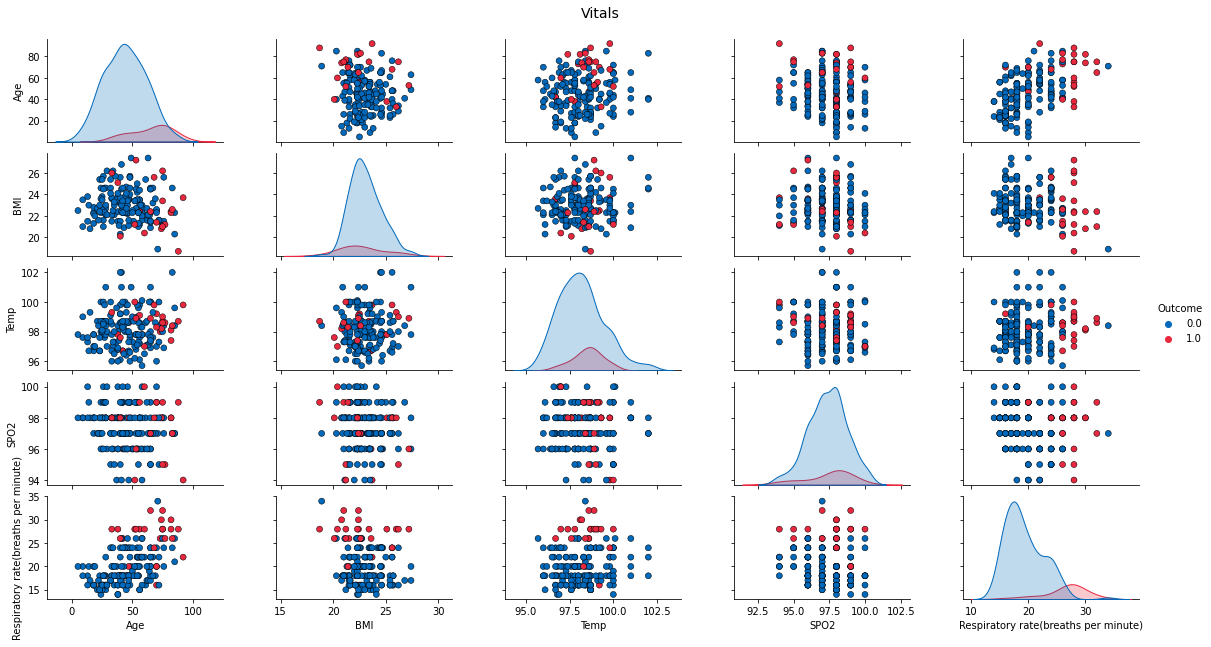

In [17]:
# Scatter Plot with Hue for visualizing data in 3-D
vitals = ['Age','BMI','Temp','SPO2','Respiratory rate(breaths per minute)','Outcome']

pp = sns.pairplot(df[vitals], hue='Outcome', size=1.8, aspect=1.8, 
                  palette={1: "#e8283e", 0: "#0069bb"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Vitals', fontsize=14)

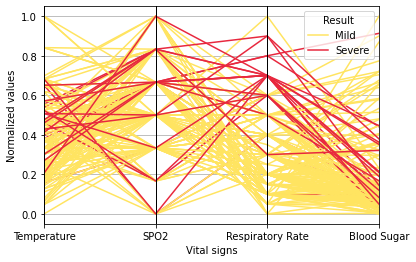

In [18]:
cols = ['Temp', 'SPO2', 'Respiratory rate(breaths per minute)','RANDOM BLOOD SUGAR']
subset_df = df[cols]

from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, df['Result']], axis=1)
final_df.head()

# plot parallel coordinates
from pandas.plotting import parallel_coordinates
pc = parallel_coordinates(final_df, 'Result', color=('#ffe461', '#e8283e'))
pc.set_xlabel("Vital signs")
pc.set_xticklabels(["Temperature","SPO2","Respiratory Rate","Blood Sugar"])
pc.set_ylabel("Normalized values")
pc.legend(title='Result')

## Symptoms Analysis

Note: '1' indicates presence of symptom, as '0' detects absence.

In [19]:
symptoms = df[['Fever','Breathlessness','Cough','Outcome']]

### Outcome with combination of symptoms or comorbidities

Chance can be expressed either as a probability or as odds. In most contexts, there is no particular reason to prefer one over the other. Most scientists tend to feel more comfortable thinking about probabilities than odds, but that is a matter of training and custom, not logic.

The distinction is simple:

- The probability that an event will occur is the fraction of times you expect to see that event in many trials. Probabilities always range between 0 and 1.

- The odds are defined as the probability that the event will occur divided by the probability that the event will not occur. It can be thought of as the probability that one thing is so or will happen rather than another. An odds of 2 means that the positive outcome is twice as likely to happen as the negative.

In [20]:
grouped_symptoms = symptoms.groupby(['Fever','Cough','Breathlessness'],as_index=False).mean().round(2)
grouped_symptoms['Odds'] = grouped_symptoms['Outcome']/(1-grouped_symptoms['Outcome'])
grouped_symptoms['Size'] = symptoms.groupby(['Fever','Cough','Breathlessness'],as_index=False).size()['size']
grouped_symptoms

,Fever,Cough,Breathlessness,Outcome,Odds,Size
0,0,0,0,0.00,0.000000,41
1,0,0,1,0.23,0.298701,13
2,0,1,0,0.00,0.000000,8
3,0,1,1,0.32,0.470588,28
4,1,0,0,0.00,0.000000,37
5,1,0,1,0.30,0.428571,10
6,1,1,0,0.09,0.098901,23
7,1,1,1,0.47,0.886792,15


The analysis showed that breathlessness is the main indicator of higher severity level, while fever was not important at all. A person exhibiting all the symptoms has a 50% chance of dying.

In [21]:
comorbidities = df[['Diabetes', 'Hypertension','Heart Condition','Outcome']]

In [22]:
grouped_com = comorbidities.groupby(['Diabetes','Hypertension','Heart Condition'],as_index=False).mean().round(2)
grouped_com['Odds'] = grouped_com['Outcome']/(1-grouped_com['Outcome'])
grouped_com['Size'] = comorbidities.groupby(['Diabetes','Hypertension','Heart Condition'],as_index=False).size()['size']
grouped_com

,Diabetes,Hypertension,Heart Condition,Outcome,Odds,Size
0,0,0,0,0.08,0.086957,93
1,0,0,1,0.00,0.000000,2
2,0,1,0,0.28,0.388889,18
3,0,1,1,0.17,0.204819,6
4,1,0,0,0.16,0.190476,19
5,1,0,1,0.33,0.492537,3
6,1,1,0,0.17,0.204819,24
7,1,1,1,0.30,0.428571,10


Due to the skewed numbers, we couldn't really make a concrete statement about the findings yet. However the chi-squared analysis showed that hypertension was the most dangerous comorbidity that affects the outcome of the patient.

In [23]:
import plotly.express as px
import pandas as pd

df['Heart'] = df['Heart Condition']
dead = df.query("Outcome==1")
alive = df.query("Outcome==0")
# theta = ['Fever','Breathlessness','Cough']
# fig = px.line_polar(symptoms, r=r, theta=theta, line_close=True)
# fig.update_traces(fill='toself')
# fig.show()
la = len(alive)
ld = len(dead)


import plotly.graph_objects as go

categories = ['Fever','Breathlessness','Cough','Hypertension','Diabetes','Heart']
ra = [len(alive.query("Fever==1"))/la*100,len(alive.query("Breathlessness==1"))/la*100,len(alive.query("Cough==1"))/la*100,len(alive.query("Hypertension==1"))/la*100,len(alive.query("Diabetes==1"))/la*100,len(alive.query("Heart==1"))/la*100]
rd = [len(dead.query("Fever==1"))/ld*100,len(dead.query("Breathlessness==1"))/ld*100,len(dead.query("Cough==1"))/ld*100,len(dead.query("Hypertension==1"))/ld*100,len(dead.query("Diabetes==1"))/ld*100,len(dead.query("Heart==1"))/ld*100]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=ra,
      theta=categories,
      fill='toself',
      name='Alive'
))
fig.add_trace(go.Scatterpolar(
      r=rd,
      theta=categories,
      fill='toself',
      name='Dead'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=True
)

fig.show()

In [ ]:
pvalues = pd.DataFrame(data=[columns=['Features','pvalue'])